In [1]:
# ======================================
# STEP 1: Install & Imports
# ======================================
!pip install kaggle --quiet

import os, gc
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [2]:
# ======================================
# STEP 2: Mount Kaggle & Download Dataset
# ======================================
# Upload your kaggle.json in Colab first!
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip -q fashion-product-images-small.zip -d fashion_data

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small
License(s): MIT
 96% 540M/565M [00:01<00:00, 318MB/s]
100% 565M/565M [00:01<00:00, 411MB/s]


In [3]:
# ======================================
# STEP 3: Load Metadata & Images
# ======================================
df = pd.read_csv("fashion_data/styles.csv", on_bad_lines="skip")
df = df.dropna(subset=["id", "masterCategory"]).reset_index(drop=True)

print("Total rows:", df.shape)

# Keep only first 2000 samples (to save RAM in Colab)
df = df.sample(n=2000, random_state=42).reset_index(drop=True)

# Image folder
img_dir = "fashion_data/images/"

# Load & resize
images, labels, ids = [], [], []
for i, row in df.iterrows():
    img_path = os.path.join(img_dir, str(row["id"])+".jpg")
    if os.path.exists(img_path):
        try:
            img = Image.open(img_path).convert("RGB").resize((224,224))
            images.append(np.array(img))
            labels.append(row["masterCategory"])
            ids.append(row["id"])
        except:
            pass

images = np.array(images)
labels = np.array(labels)
ids = np.array(ids)

print("Loaded images:", images.shape)














Total rows: (44424, 10)
Loaded images: (2000, 224, 224, 3)


In [4]:
# ======================================
# STEP 4: Feature Extraction (ResNet50 in batches)
# ======================================
resnet = ResNet50(weights="imagenet", include_top=False, pooling="avg", input_shape=(224,224,3))

batch_size = 64
features_list = []

for i in range(0, len(images), batch_size):
    batch = images[i:i+batch_size]
    batch_pre = preprocess_input(batch)
    feats = resnet.predict(batch_pre, verbose=0)
    features_list.append(feats)
    del batch, batch_pre, feats
    gc.collect()

features = np.vstack(features_list)
print("Final feature shape:", features.shape)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Final feature shape: (2000, 2048)


In [5]:
# ======================================
# STEP 5: Train KNN
# ======================================
#knn = NearestNeighbors(n_neighbors=6, metric="cosine")
#knn.fit(features)


from sklearn.neighbors import KNeighborsClassifier

# Use distance-weighted voting, cosine similarity, k=6
knn = KNeighborsClassifier(n_neighbors=15, metric="cosine", weights="distance")

# Train on features + labels
knn.fit(features, labels)


KNeighborsClassifier(metric='cosine', n_neighbors=15, weights='distance')

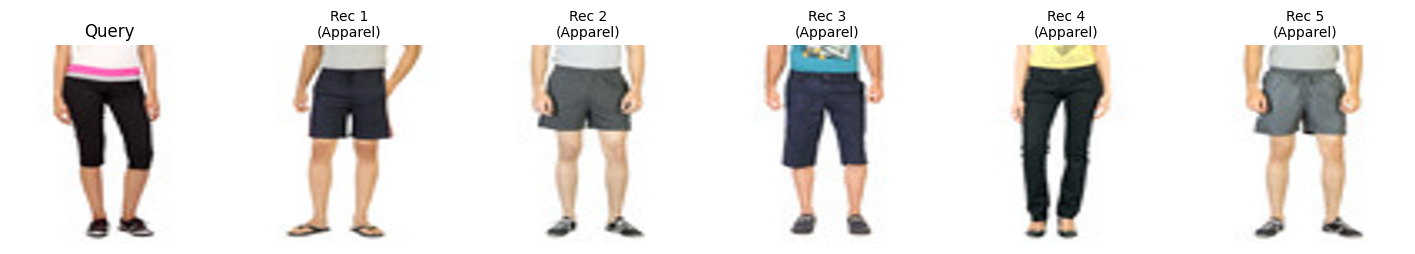

In [6]:
def recommend(img_index, top_k=5):
    """
    Displays the query image + top_k recommended images with category labels.
    """
    distances, indices = knn.kneighbors([features[img_index]], n_neighbors=top_k+1)  # +1 for query itself
    indices = indices[0]  # flatten

    plt.figure(figsize=(3*len(indices), 4))  # width scales with number of images

    for i, idx in enumerate(indices):
        plt.subplot(1, len(indices), i+1)  # dynamic subplot
        plt.imshow(images[idx])
        plt.axis("off")
        if i == 0:
            plt.title("Query")
        else:
            plt.title(f"Rec {i}\n({labels[idx]})", fontsize=10)

    plt.show()

recommend(10, top_k=5)  # shows query + 5 recommendations



In [7]:
# ======================================
# STEP 7: Accuracy & Confusion Matrix
# ======================================
# Encode labels
le = LabelEncoder()
y_true = le.fit_transform(labels)

# Predict nearest neighbor category
y_pred = []
for i in range(len(features)):
    distances, indices = knn.kneighbors([features[i]])
    neighbor_labels = labels[indices[0][1:]]  # exclude itself
    if len(neighbor_labels) > 0:
        y_pred.append(neighbor_labels[0])
    else:
        y_pred.append(labels[i])

y_pred_enc = le.transform(y_pred)

print("Classification Report:\n", classification_report(y_true, y_pred_enc))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_enc))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96       524
           1       0.99      0.99      0.99       967
           2       0.98      1.00      0.99       401
           3       0.18      0.25      0.21         8
           4       0.97      0.92      0.94        97
           5       1.00      0.67      0.80         3

    accuracy                           0.98      2000
   macro avg       0.85      0.80      0.82      2000
weighted avg       0.98      0.98      0.98      2000

Confusion Matrix:
 [[503   6   6   6   3   0]
 [  6 957   1   3   0   0]
 [  0   0 401   0   0   0]
 [  5   1   0   2   0   0]
 [  6   2   0   0  89   0]
 [  1   0   0   0   0   2]]


In [8]:
import pickle

# ======================================
# STEP 8: Save for Streamlit
# ======================================
np.save("images.npy", images)
np.save("features.npy", features)
np.save("labels.npy", labels)

with open("knn_model.pkl", "wb") as f:
    pickle.dump(knn, f)

print("✅ All files saved for Streamlit (images.npy, features.npy, labels.npy, knn_model.pkl)")


✅ All files saved for Streamlit (images.npy, features.npy, labels.npy, knn_model.pkl)


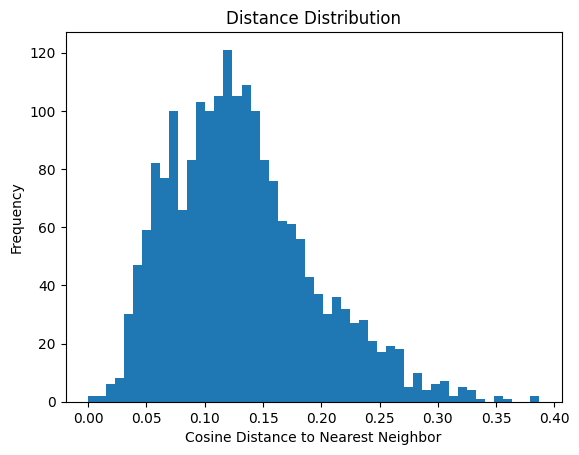

In [9]:
distances, _ = knn.kneighbors(features)
plt.hist(distances[:,1], bins=50)  # skip self-distance at index 0
plt.xlabel("Cosine Distance to Nearest Neighbor")
plt.ylabel("Frequency")
plt.title("Distance Distribution")
plt.show()



In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# ======================================
# Evaluation Function
# ======================================
def evaluate_recommendations(features, labels, k=5):
    le = LabelEncoder()
    labels_enc = le.fit_transform(labels)   # convert string → int

    y_true, y_pred = [], []
    for i in range(len(features)):
        query_label = labels_enc[i]
        distances, indices = knn.kneighbors([features[i]], n_neighbors=k+1)
        rec_indices = indices[0][1:]  # skip itself

        # Predicted label = majority class among recommendations
        rec_labels = labels_enc[rec_indices]
        pred_label = np.bincount(rec_labels).argmax()

        y_true.append(query_label)
        y_pred.append(pred_label)

    return y_true, y_pred, le

# ======================================
# Run Evaluation
# ======================================
y_true, y_pred, le = evaluate_recommendations(features, labels, k=5)

print("Classification Report:\n",
      classification_report(y_true, y_pred, target_names=le.classes_))

print("Confusion Matrix:\n",
      confusion_matrix(y_true, y_pred))


Classification Report:
                 precision    recall  f1-score   support

   Accessories       0.95      0.96      0.96       524
       Apparel       0.98      0.99      0.99       967
      Footwear       0.99      1.00      0.99       401
    Free Items       0.00      0.00      0.00         8
 Personal Care       1.00      0.89      0.94        97
Sporting Goods       0.00      0.00      0.00         3

      accuracy                           0.97      2000
     macro avg       0.65      0.64      0.65      2000
  weighted avg       0.97      0.97      0.97      2000

Confusion Matrix:
 [[503  17   4   0   0   0]
 [  7 959   1   0   0   0]
 [  0   0 401   0   0   0]
 [  7   1   0   0   0   0]
 [ 10   1   0   0  86   0]
 [  2   0   1   0   0   0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


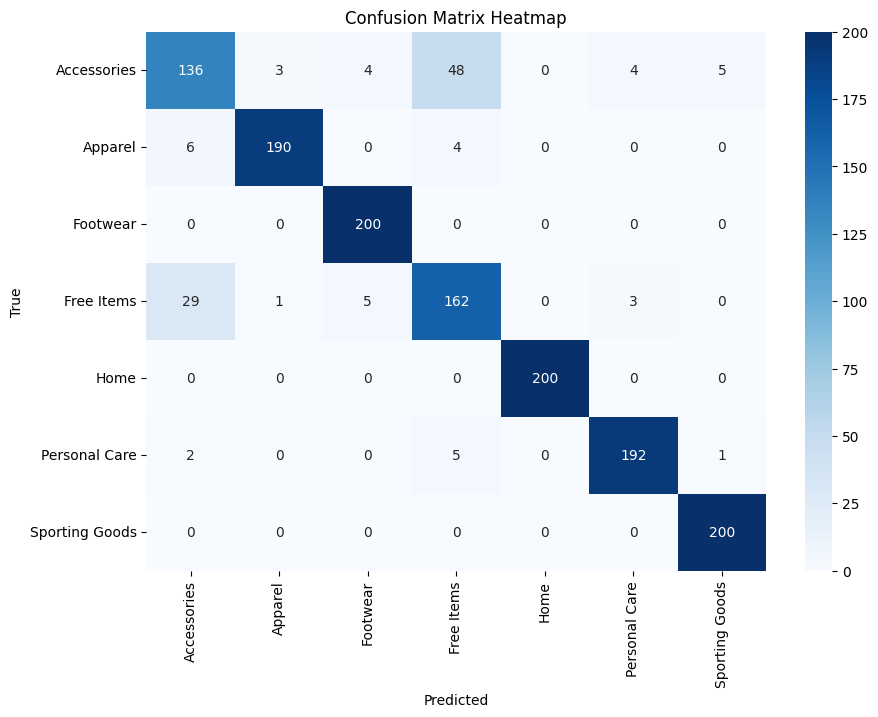

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Heatmap")
plt.show()



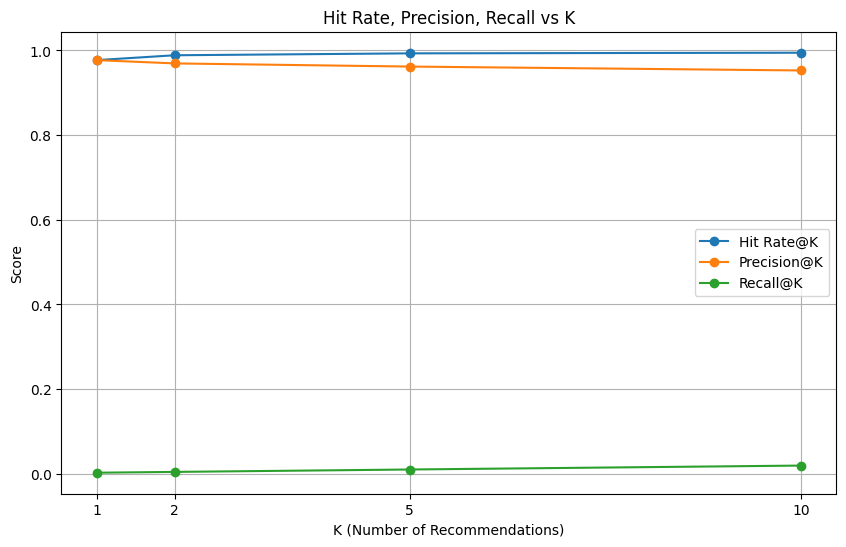

K=1 -> Hit Rate: 0.977, Precision: 0.977, Recall: 0.003
K=2 -> Hit Rate: 0.989, Precision: 0.969, Recall: 0.005
K=5 -> Hit Rate: 0.993, Precision: 0.962, Recall: 0.010
K=10 -> Hit Rate: 0.995, Precision: 0.953, Recall: 0.019


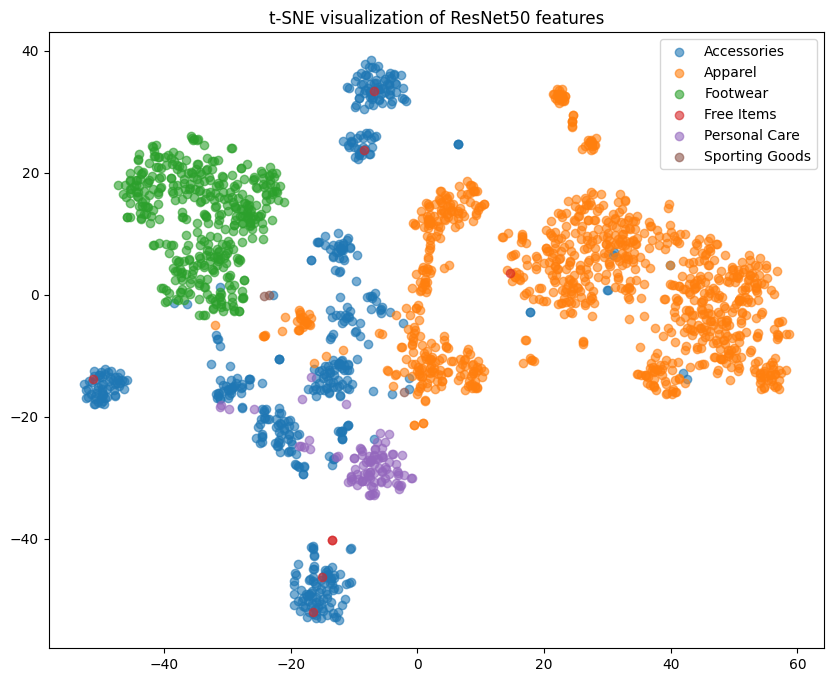

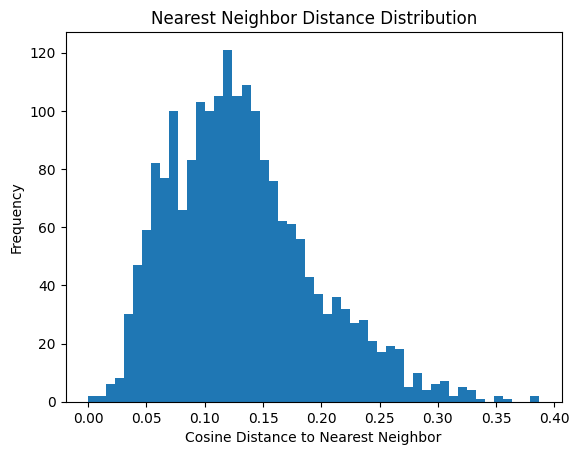

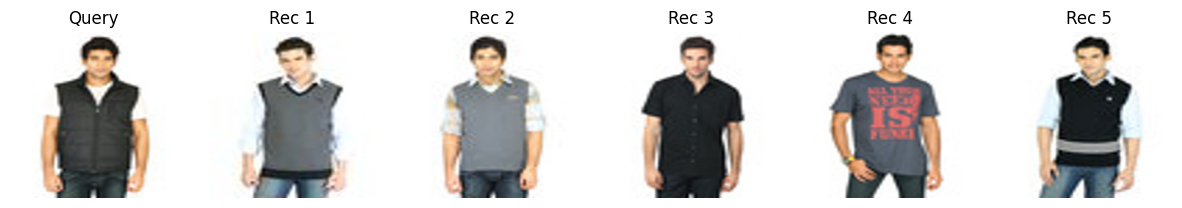

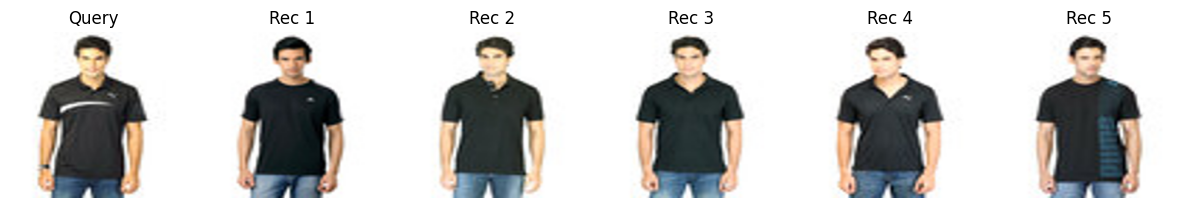

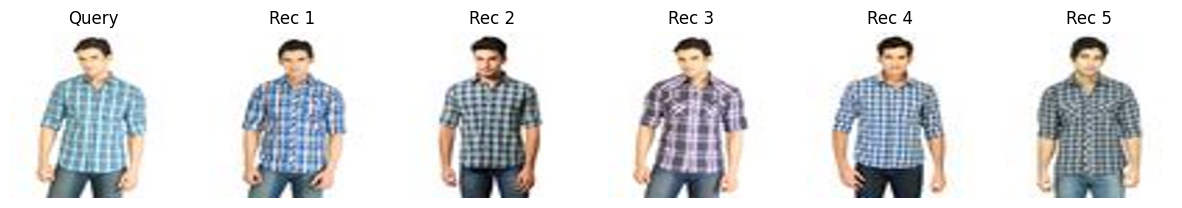

In [11]:
# =========================
# Imports
# =========================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

# =========================
# Load saved data
# =========================
features = np.load("features.npy")
images = np.load("images.npy")
labels = np.load("labels.npy")

# Load KNN model if saved, or fit a new one
knn = NearestNeighbors(n_neighbors=11, metric="cosine")  # +1 to exclude query itself later
knn.fit(features)

# =========================
# Encode labels for classification metrics
# =========================
le = LabelEncoder()
y_true = le.fit_transform(labels)

# Predict category using 1-NN
y_pred = []
for i in range(len(features)):
    distances, indices = knn.kneighbors([features[i]])
    neighbor_labels = labels[indices[0][1:]]  # exclude query itself
    y_pred.append(neighbor_labels[0])
y_pred_enc = le.transform(y_pred)


# =========================
# Recommendation metrics for multiple K
# =========================
k_values = [1, 2, 5, 10]
hit_rates, precisions, recalls = [], [], []

for top_k in k_values:
    hits, precision_list, recall_list = 0, [], []
    for i in range(len(features)):
        distances, indices = knn.kneighbors([features[i]], n_neighbors=top_k+1)
        top_labels = labels[indices[0][1:]]  # skip query itself
        relevant = (top_labels == labels[i])
        if relevant.any(): hits += 1
        precision_list.append(relevant.sum()/top_k)
        total_relevant = np.sum(labels == labels[i]) - 1
        recall_list.append(relevant.sum()/total_relevant if total_relevant>0 else 0)
    hit_rates.append(hits/len(features))
    precisions.append(np.mean(precision_list))
    recalls.append(np.mean(recall_list))

plt.figure(figsize=(10,6))
plt.plot(k_values, hit_rates, marker='o', label='Hit Rate@K')
plt.plot(k_values, precisions, marker='o', label='Precision@K')
plt.plot(k_values, recalls, marker='o', label='Recall@K')
plt.xticks(k_values)
plt.xlabel("K (Number of Recommendations)")
plt.ylabel("Score")
plt.title("Hit Rate, Precision, Recall vs K")
plt.legend()
plt.grid(True)
plt.show()

for i, k in enumerate(k_values):
    print(f"K={k} -> Hit Rate: {hit_rates[i]:.3f}, Precision: {precisions[i]:.3f}, Recall: {recalls[i]:.3f}")

# =========================
# t-SNE Visualization
# =========================
tsne = TSNE(n_components=2, random_state=42)
feat_2d = tsne.fit_transform(features)
plt.figure(figsize=(10,8))
for cat in np.unique(labels):
    idx = labels == cat
    plt.scatter(feat_2d[idx,0], feat_2d[idx,1], label=cat, alpha=0.6)
plt.legend()
plt.title("t-SNE visualization of ResNet50 features")
plt.show()

# =========================
# Distance histogram
# =========================
distances, _ = knn.kneighbors(features)
plt.hist(distances[:,1], bins=50)  # skip self-distance
plt.xlabel("Cosine Distance to Nearest Neighbor")
plt.ylabel("Frequency")
plt.title("Nearest Neighbor Distance Distribution")
plt.show()

# =========================
# Sample Recommendation Grid
# =========================
def show_recommendations(idx):
    distances, indices = knn.kneighbors([features[idx]], n_neighbors=6)
    plt.figure(figsize=(15,4))
    for i, ri in enumerate(indices[0]):
        plt.subplot(1,6,i+1)
        plt.imshow(images[ri])
        plt.axis('off')
        if i==0: plt.title("Query")
        else: plt.title(f"Rec {i}")
    plt.show()

# Show sample recommendations for 3 random queries
for q in random.sample(range(len(features)), 3):
    show_recommendations(q)


In [12]:
def top_k_accuracy(features, labels, k=5):
    correct = 0
    total = len(features)

    for i in range(total):
        distances, indices = knn.kneighbors([features[i]], n_neighbors=k+1)
        neighbor_labels = labels[indices[0][1:]]  # exclude itself

        # True if original label is among retrieved labels
        if labels[i] in neighbor_labels:
            correct += 1

    return correct / total

# Evaluate for multiple k
for k in [1, 3, 5]:
    acc = top_k_accuracy(features, labels, k)
    print(f"Top-{k} Accuracy: {acc:.4f}")




Top-1 Accuracy: 0.9770
Top-3 Accuracy: 0.9915
Top-5 Accuracy: 0.9930


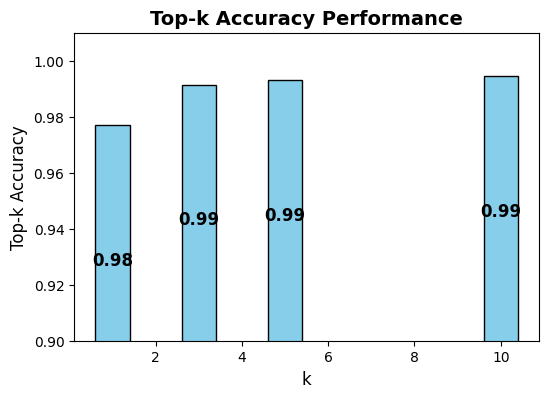

In [13]:
import matplotlib.pyplot as plt

ks = [1, 3, 5, 10]
accs = [top_k_accuracy(features, labels, k) for k in ks]

plt.figure(figsize=(6,4))
bars = plt.bar(ks, accs, color="skyblue", edgecolor="black")

# Annotate values on top of each bar
for bar, acc in zip(bars, accs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.05,
             f"{acc:.2f}", ha="center", color="black", fontsize=12, weight="bold")

plt.ylim(0.9, 1.01)
plt.xlabel("k", fontsize=12)
plt.ylabel("Top-k Accuracy", fontsize=12)
plt.title("Top-k Accuracy Performance", fontsize=14, weight="bold")
plt.show()


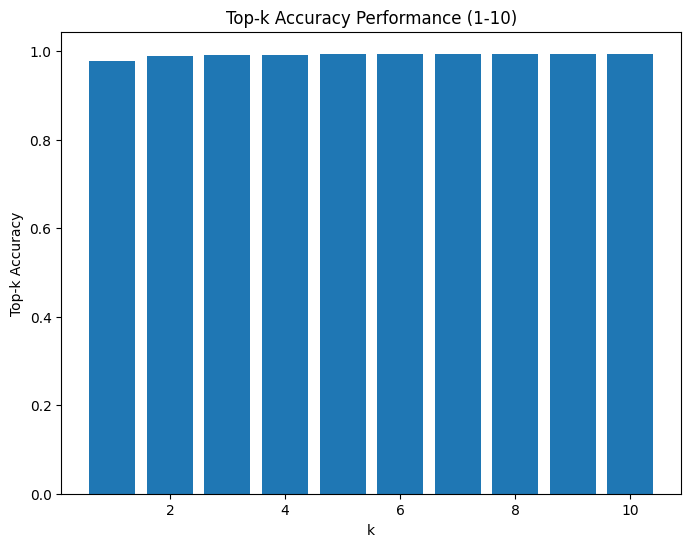

In [14]:
ks = range(1, 11)  # test k from 1 to 10
accuracies = []

for k in ks:
    acc = top_k_accuracy(features, labels, k=k)
    accuracies.append(acc)

plt.figure(figsize=(8,6))
plt.bar(ks, accuracies)
plt.xlabel("k")
plt.ylabel("Top-k Accuracy")
plt.title("Top-k Accuracy Performance (1-10)")
plt.show()
